# Data processing

# Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../data')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import resample

from constants import RENAME_DICT, DROP_COLUMNS

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from category_encoders import BinaryEncoder
import optuna
from optuna.samplers import TPESampler

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

from tqdm import tqdm
from boruta import BorutaPy

# Constants

In [13]:
NUM_FEATURES = [
        "GOLD_DENSITY",
        "SILVER_DENSITY",
        "PRECIOUS_ORE_DENSITY",
        "COPPER_GRADE",
        "INITIAL_COST",
        "ORE_TONNAGE",
        "PRECIOUS_TONNAGE",
        "COPPER_TONNAGE",
        "ECONOMIC_TONNAGE",
        "GOLD_TONNAGE",
        "SILVER_TONNAGE",
        'INITIAL_COST_PER_TONNE',
        "LOG_10_GOLD_DENSITY",
        "LOG_10_SILVER_DENSITY",
        "LOG_10_PRECIOUS_ORE_DENSITY",
        "LOG_10_COPPER_GRADE",
        "LOG_10_INITIAL_COST",
        "LOG_10_ORE_TONNAGE",
        "LOG_10_PRECIOUS_TONNAGE",
        "LOG_10_COPPER_TONNAGE",
        "LOG_10_ECONOMIC_TONNAGE",
        "LOG_10_GOLD_TONNAGE",
        "LOG_10_SILVER_TONNAGE",
        'LOG_10_INITIAL_COST_PER_TONNE'
        #Adicionar custo por tonelada
        #Capacidade de processamento
        #"PRICE_PER_TONNE_MAIN_ORE",
    ]

TO_LOG10 = [
    "GOLD_DENSITY",
    "SILVER_DENSITY",
    "PRECIOUS_ORE_DENSITY",
    "COPPER_GRADE",
    "INITIAL_COST",
    "ORE_TONNAGE",
    "PRECIOUS_TONNAGE",
    "COPPER_TONNAGE",
    "ECONOMIC_TONNAGE",
    "GOLD_TONNAGE",
    "SILVER_TONNAGE",
    'INITIAL_COST_PER_TONNE',

]

CAT_FEATURES = [
    "GEOLOGIC_ORE_BODY_TYPE",
    "GLOBAL_REGION",
    "MINE_TYPE"
]

FEATURES = NUM_FEATURES + CAT_FEATURES

FILL_COLS = ['COPPER_GRADE', 'LEAD_GRADE', 'ZINC_GRADE',
       'GOLD_DENSITY', 'SILVER_DENSITY']

# Data Loading

In [3]:
raw_copper_mines_df = pd.read_excel('../data/raw/Cu_v2.xls', decimal=',', thousands='.')
raw_copper_mines_df.rename(columns=RENAME_DICT, inplace=True)

# Preprocessamento

In [4]:
raw_copper_mines_df.rename(columns=RENAME_DICT, inplace=True)

# Fill specified columns with NaN where 'y' is 0
raw_copper_mines_df.loc[raw_copper_mines_df['ORE_TONNAGE'] == 0, FILL_COLS] = np.nan

raw_copper_mines_df['ORE_TONNAGE'].replace(0, np.nan, inplace=True)
#raw_copper_mines_df.drop(columns=DROP_COLUMNS, inplace=True)
raw_copper_mines_df.dropna(how='all', inplace=True)

# Feature Engineering

In [5]:
raw_copper_mines_df['COPPER_GRADE'] = raw_copper_mines_df['COPPER_GRADE']/100

raw_copper_mines_df['PRECIOUS_ORE_DENSITY'] = raw_copper_mines_df['GOLD_DENSITY'] + raw_copper_mines_df['SILVER_DENSITY']
raw_copper_mines_df['GOLD_TONNAGE'] = raw_copper_mines_df['ORE_TONNAGE'] * raw_copper_mines_df['GOLD_DENSITY']
raw_copper_mines_df['SILVER_TONNAGE'] = raw_copper_mines_df['ORE_TONNAGE'] * raw_copper_mines_df['SILVER_DENSITY']
raw_copper_mines_df['PRECIOUS_TONNAGE'] = raw_copper_mines_df['ORE_TONNAGE'] * raw_copper_mines_df['PRECIOUS_ORE_DENSITY']
raw_copper_mines_df['COPPER_TONNAGE'] = raw_copper_mines_df['ORE_TONNAGE'] * raw_copper_mines_df['COPPER_GRADE']
raw_copper_mines_df['ECONOMIC_TONNAGE'] = (raw_copper_mines_df['COPPER_TONNAGE'] + raw_copper_mines_df['PRECIOUS_TONNAGE'])
#raw_copper_mines_df['GLOBAL_REGION'] = raw_copper_mines_df['GLOBAL_REGION'].apply(lambda x: "Africa-Europe-Middle East" if x in ["Africa", "Europe", "Middle East"] else x)
raw_copper_mines_df['GEOLOGIC_ORE_BODY_TYPE'] = raw_copper_mines_df['GEOLOGIC_ORE_BODY_TYPE'].apply(lambda x: "SKARN-SHD" if x in ["SKARN", "SHD"] else x)
raw_copper_mines_df['INITIAL_COST_PER_TONNE'] = raw_copper_mines_df['INITIAL_COST'] / raw_copper_mines_df['ECONOMIC_TONNAGE']
raw_copper_mines_df['PRICE_PER_TONNE_MAIN_ORE'] = raw_copper_mines_df['PRICE_PER_TONNE_MAIN_ORE'].fillna(-1)
raw_copper_mines_df['MINE_TYPE'] = raw_copper_mines_df['MINE_TYPE'].apply(lambda x: "Open Pit" if x in ["In-Situ Leach", "Tailings"] else x)

for col in TO_LOG10:
    raw_copper_mines_df['LOG_10_' + col] = np.log10(raw_copper_mines_df[col])
    raw_copper_mines_df['LOG_10_' + col].replace(-np.inf, -100, inplace=True)

# Separação de treino e teste

In [6]:
raw_copper_mines_df = raw_copper_mines_df.dropna(subset=['TIR'])
X = raw_copper_mines_df[FEATURES]
y = raw_copper_mines_df['TIR']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=94, random_state=42)

X_train = X_train[y_train < 125]
y_train = y_train[y_train < 125]

traind_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

y_train_cat = y_train < 15
y_test_cat = y_test < 15


del y_train
del y_test
del X
del y

print(X_train.shape)
print(X_test.shape)

(100, 27)
(94, 27)


# EDA

In [8]:
y_train_cat.value_counts()/y_train_cat.shape[0]

TIR
False    0.85
True     0.15
Name: count, dtype: float64

In [9]:
X_train.isnull().sum()/X_train.shape[0]

GOLD_DENSITY                     0.02
SILVER_DENSITY                   0.02
PRECIOUS_ORE_DENSITY             0.02
COPPER_GRADE                     0.02
INITIAL_COST                     0.04
ORE_TONNAGE                      0.02
PRECIOUS_TONNAGE                 0.02
COPPER_TONNAGE                   0.02
ECONOMIC_TONNAGE                 0.02
GOLD_TONNAGE                     0.02
SILVER_TONNAGE                   0.02
INITIAL_COST_PER_TONNE           0.06
LOG_10_GOLD_DENSITY              0.02
LOG_10_SILVER_DENSITY            0.02
LOG_10_PRECIOUS_ORE_DENSITY      0.02
LOG_10_COPPER_GRADE              0.02
LOG_10_INITIAL_COST              0.04
LOG_10_ORE_TONNAGE               0.02
LOG_10_PRECIOUS_TONNAGE          0.02
LOG_10_COPPER_TONNAGE            0.02
LOG_10_ECONOMIC_TONNAGE          0.02
LOG_10_GOLD_TONNAGE              0.02
LOG_10_SILVER_TONNAGE            0.02
LOG_10_INITIAL_COST_PER_TONNE    0.06
GEOLOGIC_ORE_BODY_TYPE           0.03
GLOBAL_REGION                    0.00
MINE_TYPE   

In [10]:
X_train["GEOLOGIC_ORE_BODY_TYPE"].value_counts()

GEOLOGIC_ORE_BODY_TYPE
PCD      42
VMS      18
SHD      15
IOCG     12
SKARN    10
Name: count, dtype: int64

In [11]:
X_train["GLOBAL_REGION"].value_counts()

GLOBAL_REGION
United States and Canada       26
Latin America and Caribbean    26
Asia-Pacific                   25
Africa                         14
Europe                          8
Middle East                     1
Name: count, dtype: int64

In [12]:
X_train["MINE_TYPE"].value_counts()

#In-Situ Leach, Tailings -> Open Pit

MINE_TYPE
Open Pit         70
Underground      24
In-Situ Leach     3
Tailings          2
Name: count, dtype: int64

# Seleção de features com Boruta

In [32]:
categorical_transformer = Pipeline(steps=[
    ('binary_encoder', BinaryEncoder())
])

scaler_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
])

fillna_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
])

preprocessor = ColumnTransformer(
                transformers=[
                    ('num', scaler_transformer, NUM_FEATURES),
                    ('cat', categorical_transformer, CAT_FEATURES),
                    ('fillna', fillna_transformer, slice(0, None))
                ]
            )

model = RandomForestClassifier(
            n_estimators=15,
            max_depth=3,
            max_features=3,
            min_samples_split=4,
            min_samples_leaf=1,
            random_state=42,
            n_jobs=-1,
            class_weight='balanced'
        )

# define Boruta feature selection method
feat_selector = BorutaPy(model, n_estimators='auto', random_state=1)

# find all relevant features - 5 features should be selected
feat_selector.fit(X_train_knn_res.values, y_train_knn_res.astype("int32").values)

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=3,
                                          max_features=3, min_samples_split=4,
                                          n_estimators=230, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x7FBEF0643B40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7FBEF0643B40)

Text(0, 0.5, 'Features')

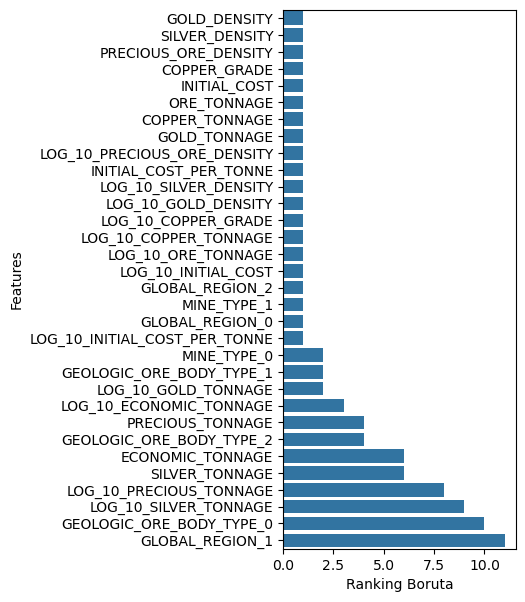

In [33]:
feature_importance = pd.Series(feat_selector.ranking_, index = X_train_knn.columns).sort_values(ascending=True)
plt.figure(figsize=(3, 7))
sns.barplot(x=feature_importance, y=feature_importance.index, orient='h')
plt.xlabel("Ranking Boruta")
plt.ylabel("Features")



## PCA

In [15]:
binary_encoder = BinaryEncoder(cols=CAT_FEATURES)
X_train_cat = binary_encoder.fit_transform(X_train[CAT_FEATURES])
X_test_cat = binary_encoder.transform(X_test[CAT_FEATURES])

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[NUM_FEATURES])
X_test_scaled = scaler.transform(X_test[NUM_FEATURES])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=NUM_FEATURES, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=NUM_FEATURES, index=X_test.index)

X_train_pro = pd.concat([X_train_scaled, X_train_cat], axis=1)
X_test_pro = pd.concat([X_test_scaled, X_test_cat], axis=1)

imputer = KNNImputer(n_neighbors=3)
X_train_knn = imputer.fit_transform(X_train_pro)
X_test_knn = imputer.transform(X_test_pro)

X_train_knn = pd.DataFrame(X_train_knn, columns=X_train_pro.columns, index=X_train_pro.index)
X_test_knn = pd.DataFrame(X_test_knn, columns=X_test_pro.columns, index=X_test_pro.index)

#over = SMOTE(sampling_strategy="auto")
#X_train_knn_res, y_train_knn_res = over.fit_resample(X_train_knn, y_train_cat)
    
#under = RandomUnderSampler(sampling_strategy="auto")
#X_train_knn_res, y_train_knn_res = under.fit_resample(X_train_knn_res, y_train_knn_res)

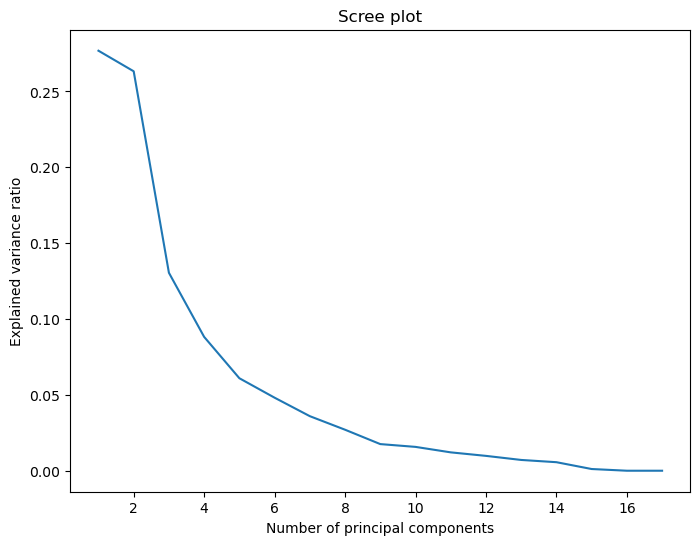

In [16]:
# Perform PCA
pca = PCA()
pca.fit(X_train_knn[NUM_SELECTED])

# Get the principal components
principal_components = pca.components_

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.xlabel('Number of principal components')
plt.ylabel('Explained variance ratio')
plt.title('Scree plot')
plt.show()

In [17]:
# Perform PCA
pca = PCA(n_components=6)
PCA_COLS = [f'PCA{i+1}' for i in range(6)]

X_train_pca = pca.fit_transform(X_train_knn[NUM_SELECTED])
X_train_pca = pd.DataFrame(X_train_pca, columns=PCA_COLS, index=X_train.index)

X_test_pca = pca.transform(X_test_knn[NUM_SELECTED])
X_test_pca = pd.DataFrame(X_test_pca, columns=PCA_COLS, index=X_test.index)

# Testing

In [19]:
X_train_ref = pd.concat([X_train_pca, X_train_cat[CAT_SELECTED]], axis=1)
X_test_ref = pd.concat([X_test_pca, X_test_cat[CAT_SELECTED]], axis=1)

In [20]:
over = SMOTE(sampling_strategy="auto")
X_train_res, y_train_res = over.fit_resample(X_train_ref, y_train_cat)
    
under = RandomUnderSampler(sampling_strategy="auto")
X_train_res, y_train_res = under.fit_resample(X_train_res, y_train_res)

In [42]:
model = RandomForestClassifier(
            n_estimators=100,
            max_depth=3,
            max_features=6,
            min_samples_split=4,
            min_samples_leaf=1,
            random_state=42,
            n_jobs=-1,
            class_weight='balanced'
        ).fit(X_train_res, y_train_res)


In [43]:
common_params = {
    "X": X_train_res,
    "y": y_train_res,
    "train_sizes": np.linspace(0.15, 1.0, 10),
    "cv": ShuffleSplit(n_splits=15, test_size=0.30, random_state=0),
    "scoring": "roc_auc",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
}

Text(0.5, 1.0, 'Learning Curve for RandomForestClassifier')

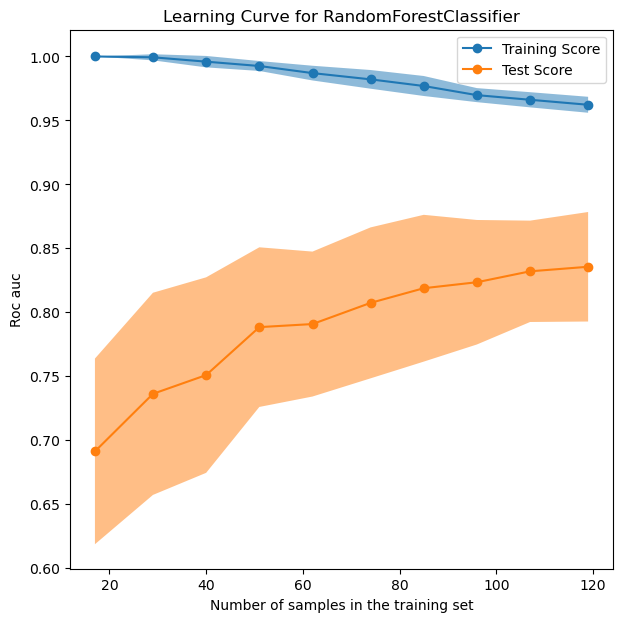

In [44]:
fig, ax = plt.subplots(figsize=(7, 7), sharey=True)

LearningCurveDisplay.from_estimator(model, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {model.__class__.__name__}")

In [45]:
y_prob = model.predict_proba(X_train_ref)[:, 1]

roc_auc = roc_auc_score(y_train_cat, y_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")

bootstrap_dataframes = [X_train_ref.sample(X_train_ref.shape[0], replace=True) for _ in range(1000)]

lines = []

for i, df in tqdm(enumerate(bootstrap_dataframes)):

    y_prob = model.predict_proba(df.values)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_train_cat[df.index].values, y_prob)
    line_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Threshold': thresholds, 'Bootstrap': i})
    lines.append(line_df)

roc_df = pd.concat(lines)

ROC AUC Score: 0.9286


1000it [00:26, 37.06it/s]


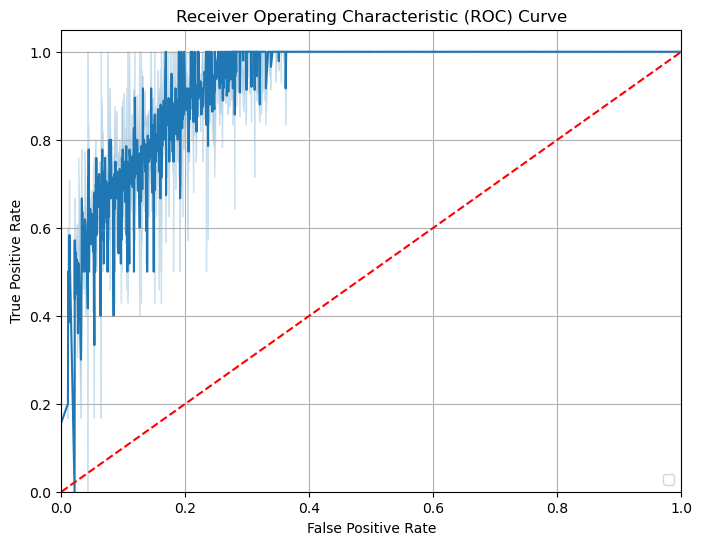

In [46]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='FPR', y='TPR', data=roc_df, estimator='median')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [47]:
y_prob = model.predict_proba(X_test_ref)[:, 1]

roc_auc = roc_auc_score(y_test_cat, y_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")

bootstrap_dataframes = [X_test_ref.sample(X_test_ref.shape[0], replace=True) for _ in range(1000)]

def get_bootstrap_roc_curve(model, df, y_test, i):

    y_prob = model.predict_proba(df)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test[df.index], y_prob)
    line_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Threshold': thresholds, 'Bootstrap': i})

    return line_df

lines = [get_bootstrap_roc_curve(model, df, y_test_cat, i) for i, df in tqdm(enumerate(bootstrap_dataframes))]

#for i, df in tqdm(enumerate(bootstrap_dataframes)):

#    y_prob = model.predict_proba(df)[:, 1]
#    fpr, tpr, thresholds = roc_curve(y_test_cat[df.index], y_prob)
#    line_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Threshold': thresholds, 'Bootstrap': i})
#    lines.append(line_df)

roc_df = pd.concat(lines)


ROC AUC Score: 0.6341


1000it [00:27, 35.74it/s]


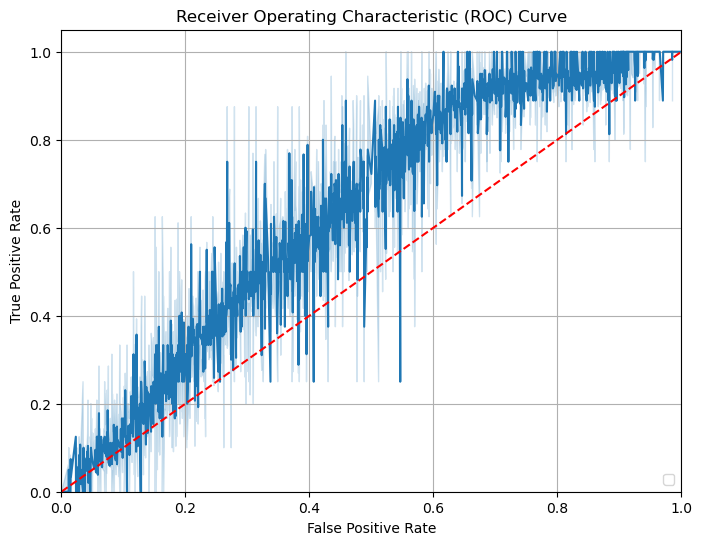

In [48]:

# Step 7: Plot the ROC curve
plt.figure(figsize=(8, 6))
sns.lineplot(x='FPR', y='TPR', data=roc_df, estimator='median')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()